 # Cozmo Neural Control (LSTM)


This experiment will attempt to control the Cozmo robot in a manner similar to what was taught to it by a human by first recording the state of the robot as it moves along at a fixed sampling rate and then training a neural network to attempt to reproduce it.

This notebook uses the network trained in *BasicNeuralTrainingLSTM.ipynb* to control the robot using the Cozmo API

For a detailed description of the experiment, refer to *BasicNeuralTrainingLSTM.ipynb*

In [ ]:
import cozmo
import tensorflow as tf
import numpy as np
import time
import asyncio
K = tf.keras
from matplotlib import pyplot as plt

In [ ]:
%run "RemoteControlLite.ipynb"

In [5]:
class RobotController:
    ACTIONS = [
        'drive_forwards',
        'drive_back',
        'turn_left',
        'turn_right',
        'lift_up',
        'lift_down',
        'head_up',
        'head_down'
    ]
    DEFAULT_ACTION_THRESHOLD = 0.35
    
    def __init__(self, rc, model_file_name, horizon=32):
        self.rc = rc
        self.robot = self.rc.cozmo
        self.action_threshold = self.DEFAULT_ACTION_THRESHOLD
        self._default_cube_positions = self._get_default_cube_positions()
        self._load_model(model_file_name)
        self.horizon = horizon
        self._init_control_matrix()
        self.steps = 0
    
    def _load_model(self, model_file_name):
        self.model = K.models.load_model(model_file_name)
        
    def _init_control_matrix(self):
        control_data = self.get_control_data()
        self.control_matrix = np.zeros((self.horizon, len(control_data)))
        
    def _get_default_cube_positions(self):
        cube_positions = {}
        for cube_id in range(1, 4):
            cube_positions[f'cube_{cube_id}_visible'] =  False
            cube_positions[f'cube_{cube_id}_x'] = 0.
            cube_positions[f'cube_{cube_id}_y'] = 0.
        return cube_positions
        
    
    def get_cube_positions(self):
        cube_positions = dict(**self._default_cube_positions)
        cubes = [obj for obj in self.rc.cozmo.world.visible_objects
                 if isinstance(obj, cozmo.objects.LightCube)]
        for cube in cubes:
            cube_positions[f'cube_{cube.cube_id}_visible'] = True
            cube_positions[f'cube_{cube.cube_id}_x'] = cube.pose.position.x
            cube_positions[f'cube_{cube.cube_id}_y'] = cube.pose.position.y
        return cube_positions
            
    def get_control_data(self):
        robot_positions = {
            'robot_position_x': self.robot.pose.position.x,
            'robot_position_y': self.robot.pose.position.y,
            'robot_angle': self.robot.pose.rotation.angle_z.radians,
        }
        cube_positions = self.get_cube_positions()
        actions = {
            'action_drive_forwards': self.rc.drive_forwards, 
            'action_drive_back': self.rc.drive_back,
            'action_turn_left': self.rc.turn_left,
            'action_turn_right': self.rc.turn_right,
            'action_lift_up': self.rc.lift_up,
            'action_lift_down': self.rc.lift_down,
            'action_head_up': self.rc.head_up,
            'action_head_down': self.rc.head_down             
        }
        data = {}
        data.update(robot_positions)
        data.update(cube_positions)
        data.update(actions)
        return data
    
    def control(self):
        control_data = self.get_control_data()
        control_vector = np.expand_dims(
            np.array(list(control_data.values())),
            axis=0
        )
        self.control_matrix = np.roll(
            self.control_matrix,
            shift=-1,
            axis=0)
        self.control_matrix[-1,:] = control_vector
        self.steps += 1
        # No need to attempt prediction if the horizon has not been reached
        if self.steps >= self.horizon:             
            output = self.model.predict(np.expand_dims(self.control_matrix, axis=0))
            action_activations = output[0]
        else:
            action_activations = np.zeros(len(self.ACTIONS))
        self._run_actions(action_activations)
        return action_activations
        
    def _run_actions(self, output):
        actions = [(action, value > self.action_threshold)
                   for action, value in zip(self.ACTIONS, output)]
        for action, value in actions:
            setattr(self.rc, action, float(value))
        if (all(not value for _, value in actions)):
            self.rc.drive_forwards = 1.0
        self.rc.update_all()

<IPython.core.display.Javascript object>


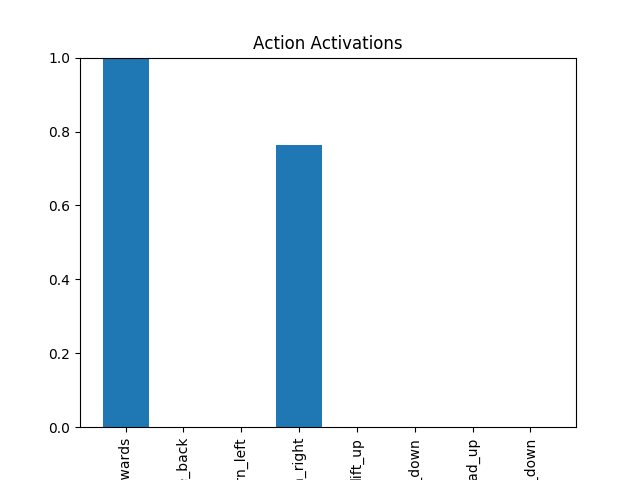

2019-01-06 23:10:15,265 cozmo.general INFO     App connection established. sdk_version=1.4.7 cozmoclad_version=3.1.0 app_build_version=00003.00001.00000
2019-01-06 23:10:15,265 cozmo.general INFO     App connection established. sdk_version=1.4.7 cozmoclad_version=3.1.0 app_build_version=00003.00001.00000
2019-01-06 23:10:15,265 cozmo.general INFO     App connection established. sdk_version=1.4.7 cozmoclad_version=3.1.0 app_build_version=00003.00001.00000
2019-01-06 23:10:15,279 cozmo.general INFO     Found robot id=1
2019-01-06 23:10:15,279 cozmo.general INFO     Found robot id=1
2019-01-06 23:10:15,279 cozmo.general INFO     Found robot id=1
2019-01-06 23:10:15,299 cozmo.general INFO     Connected to iOS device_id=10 serial=6652b41031b84511571c46b7d8754074b25476bc
2019-01-06 23:10:15,299 cozmo.general INFO     Connected to iOS device_id=10 serial=6652b41031b84511571c46b7d8754074b25476bc
2019-01-06 23:10:15,299 cozmo.general INFO     Connected to iOS device_id=10 serial=6652b41031b8451

2019-01-06 23:16:27,022 cozmo.general INFO     Robot delocalized - invalidating poses for all objects
2019-01-06 23:16:27,022 cozmo.general INFO     Robot delocalized - invalidating poses for all objects
2019-01-06 23:16:44,335 cozmo.protocol INFO     EOF received on connection
2019-01-06 23:16:44,335 cozmo.protocol INFO     EOF received on connection
2019-01-06 23:16:44,335 cozmo.protocol INFO     EOF received on connection
2019-01-06 23:16:44,388 cozmo.general INFO     Aborting connection: Lost connection to the device
2019-01-06 23:16:44,388 cozmo.general INFO     Aborting connection: Lost connection to the device
2019-01-06 23:16:44,388 cozmo.general INFO     Aborting connection: Lost connection to the device
2019-01-06 23:16:44,396 cozmo.general ERROR    Lost connection to the device: None
2019-01-06 23:16:44,396 cozmo.general ERROR    Lost connection to the device: None
2019-01-06 23:16:44,396 cozmo.general ERROR    Lost connection to the device: None
2019-01-06 23:16:44,406 cozm

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots()
ax.set_title('Action Activations')
ax.set_ylim(0.0, 1.0)
actions_range = range(len(RobotController.ACTIONS))
activation_chart = ax.bar(actions_range, np.zeros(len(RobotController.ACTIONS)))
ax.set_xticks(actions_range)
ax.set_xticklabels(RobotController.ACTIONS, rotation=90)


def main(robot):
    rc = RemoteControlLite(robot)
    controller = RobotController(rc, 'basic_neural_control_lstm.h5')
    while True:
        action_activations = controller.control()
        for rect, value in zip(activation_chart, action_activations):
            rect.set_height(value)        
        fig.canvas.draw()
        time.sleep(0.25)

plt.show()
cozmo.run_program(main)
